In [1]:
import sys
sys.path.insert(0, 'pipeline_code')
from mixed_data import create_pipeline
from cross_validation import Stratified10KFoldValidation

In [2]:
import pandas as pd

file = pd.read_csv("datasets/Domestic violence.csv")
file

,SL. No,Age,Education,Employment,Income,Marital status,Violence
0,1,30,secondary,unemployed,0,married,yes
1,2,47,tertiary,unemployed,0,married,no
2,3,24,tertiary,unemployed,0,unmarred,no
3,4,22,tertiary,unemployed,0,unmarred,no
4,5,50,primary,unemployed,0,married,yes
...,...,...,...,...,...,...,...
342,343,27,tertiary,semi employed,30000,unmarred,no
343,344,26,tertiary,employed,35000,married,no
344,345,27,primary,unemployed,0,married,yes
345,346,29,primary,unemployed,0,married,no


In [3]:
from sklearn.model_selection import train_test_split

data, labels = file.drop(columns=["SL. No", "Violence "]), file["Violence "]
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.05, random_state=0, stratify=labels)

train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((329, 5), (18, 5), (329,), (18,))

In [4]:
for column in train_data.columns:
    if train_data[column].dtype == "object":
        train_data[column] = train_data[column].astype("category")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 40 to 26
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Age              329 non-null    int64   
 1   Education        329 non-null    category
 2   Employment       329 non-null    category
 3   Income           329 non-null    int64   
 4   Marital status   329 non-null    category
dtypes: category(3), int64(2)
memory usage: 9.2 KB


In [5]:
import numpy as np

for col in train_data.columns:
    if train_data[col].dtype == "category":
        print(col, np.unique(train_data[col]))

Education  ['none' 'primary' 'secondary' 'tertiary']
Employment  ['employed' 'employed ' 'semi employed' 'unemployed']
Marital status  ['married' 'unmarred']


In [6]:
for index, row in train_data.iterrows():
    if str(train_data.loc[index, 'Employment ']) == 'employed ': 
        train_data.loc[index, 'Employment '] = 'employed'

In [7]:
numeric_features = ['Age', 'Income']
categorical_features = ['Marital status ', 'Education ', 'Employment ']
ordinal_columns = {'cat__Employment ': ['unemployed', 'semi employed', 'employed'], 
                   'cat__Education ': ['none', 'primary', 'secondary', 'tertiary']}

In [8]:
param_grid_RandomForest = {
    "feature_selector__k": range(1, 6),

    "oversampler__k_neighbors": range(3, 6, 2),
    "oversampler__borderline": [True, False],
    
    "model__estimator__max_depth": range(2, 8),
    "model__estimator__criterion": ["gini", "entropy"],
}

param_grid_KNNeighbor = {
    "feature_selector__k": range(1, 6),
    
    "oversampler__k_neighbors": range(3, 6, 2),
    "oversampler__borderline": [True, False],
    
    "model__n_neighbors": range(3, 14, 2),
}

param_grid_AdaBoostGNB = {
    "feature_selector__k": range(1, 6),
    
    "oversampler__k_neighbors": range(3, 6, 2),
    "oversampler__borderline": [True, False],
    
    "model__learning_rate": [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5],
}

param_grid_NeuralNetwork = {
    "feature_selector__k": range(1, 6),

    "oversampler__k_neighbors": range(3, 6, 2),
    "oversampler__borderline": [True, False],
    
    "model__hidden_layer_sizes": [(32,), (32, 32, ), (64,), (64, 64, )],
    "model__activation": ["relu", "logistic"],
    "model__learning_rate": ['adaptive', 'constant']
}

In [9]:
from sklearn.preprocessing import RobustScaler

clf_RandomForest = create_pipeline(
        numerical_features=numeric_features,
        categorical_features=categorical_features,
        imputers_needed=False,
        scaler=RobustScaler(),
        oversample_needed=True,
        target=labels,
        model="RandomForestClf"
    )

clf_KNNeighbor = create_pipeline(
        numerical_features=numeric_features,
        categorical_features=categorical_features,
        imputers_needed=False,
        scaler=RobustScaler(),
        oversample_needed=True,
        target=labels,
        model="KNNClf"
    )

clf_AdaBoostGNB = create_pipeline(
        numerical_features=numeric_features,
        categorical_features=categorical_features,
        imputers_needed=False,
        scaler=RobustScaler(),
        oversample_needed=True,
        target=labels,
        model="AdaBoostGaussianNB"
    )

clf_NeuralNetwork = create_pipeline(
        numerical_features=numeric_features,
        categorical_features=categorical_features,
        ordinal_columns=ordinal_columns,
        imputers_needed=False,
        scaler=RobustScaler(),
        oversample_needed=True,
        target=labels,
        model="NeuralNetworkClf"
    )

In [10]:
clf_NeuralNetwork

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Income']),
                                                 ('cat', 'passthrough',
                                                  ['Marital status ',
                                                   'Education ',
                                                   'Employment '])])),
                ('feature_selector', MutualInfoFeatureSelector()),
                ('oversampler', SMOTE_ENC(sampling_strategy='minority')),
                ('encoder',
                 DynamicColumnEncoder(ordinal_columns={'cat__Education ': ['none',
                                                                           'primary',
                                                                           'secondary',
                                                                           'tertiary'],
                                                       'cat__Employment ': ['unemployed',
                                                                            'semi '
                                                                            'employed',
                                                                            'employed']})),
                ('model', MLPClassifier(random_state=0))])

In [11]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scorer = "f1_macro"

              precision    recall  f1-score   support

          no       0.92      0.44      0.59        25
         yes       0.33      0.88      0.48         8

    accuracy                           0.55        33
   macro avg       0.62      0.66      0.54        33
weighted avg       0.78      0.55      0.57        33

              precision    recall  f1-score   support

          no       0.87      0.52      0.65        25
         yes       0.33      0.75      0.46         8

    accuracy                           0.58        33
   macro avg       0.60      0.64      0.56        33
weighted avg       0.74      0.58      0.60        33

              precision    recall  f1-score   support

          no       0.91      0.40      0.56        25
         yes       0.32      0.88      0.47         8

    accuracy                           0.52        33
   macro avg       0.61      0.64      0.51        33
weighted avg       0.77      0.52      0.53        33

              preci

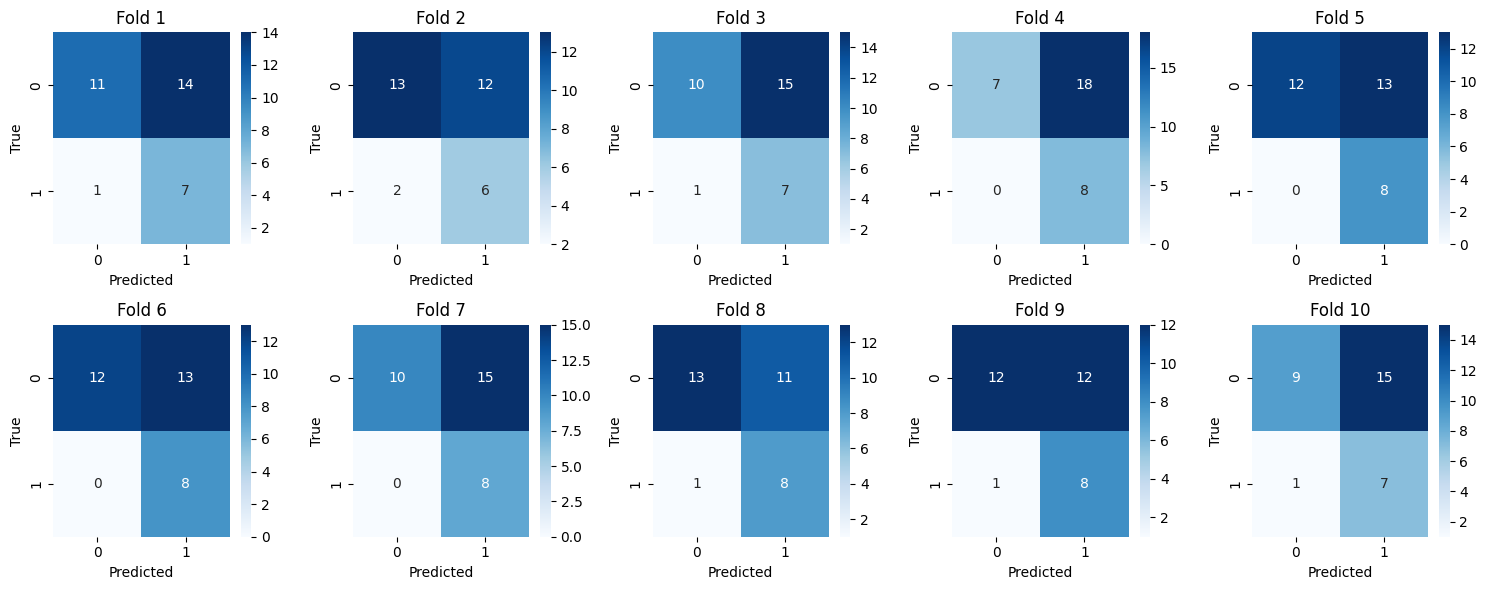

Model best parameters: {'oversampler__k_neighbors': 3, 'oversampler__borderline': True, 'model__estimator__max_depth': 5, 'model__estimator__criterion': 'gini', 'feature_selector__k': 4}


In [12]:
f_macro_scores1 = []
clfRF, best_params, reports = \
    Stratified10KFoldValidation(clf_RandomForest, param_grid_RandomForest, train_data, train_labels, scorer, skf)
print("Model best parameters:", best_params)
for report in reports:
    f_macro_scores1.append(report["macro avg"]["f1-score"])

              precision    recall  f1-score   support

          no       0.78      0.72      0.75        25
         yes       0.30      0.38      0.33         8

    accuracy                           0.64        33
   macro avg       0.54      0.55      0.54        33
weighted avg       0.67      0.64      0.65        33

              precision    recall  f1-score   support

          no       0.74      0.68      0.71        25
         yes       0.20      0.25      0.22         8

    accuracy                           0.58        33
   macro avg       0.47      0.47      0.47        33
weighted avg       0.61      0.58      0.59        33

              precision    recall  f1-score   support

          no       0.91      0.80      0.85        25
         yes       0.55      0.75      0.63         8

    accuracy                           0.79        33
   macro avg       0.73      0.78      0.74        33
weighted avg       0.82      0.79      0.80        33

              preci

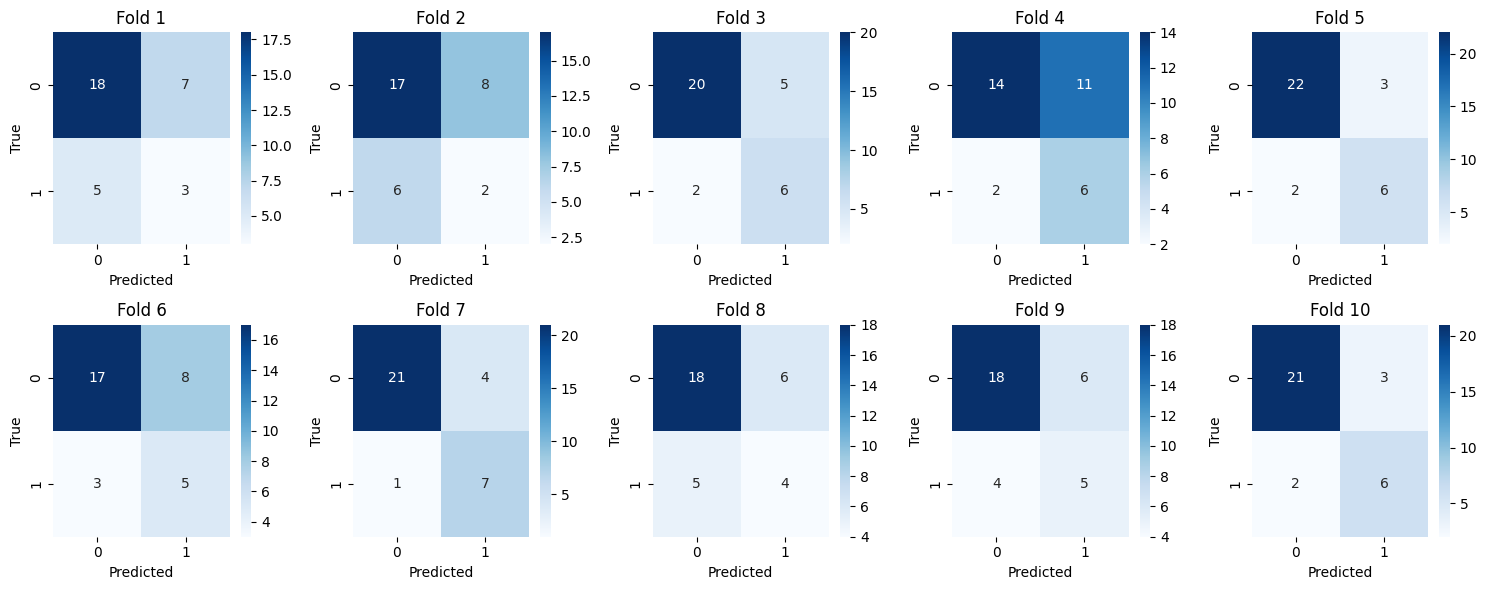

Model best parameters: {'oversampler__k_neighbors': 3, 'oversampler__borderline': False, 'model__n_neighbors': 13, 'feature_selector__k': 4}


In [13]:
f_macro_scores2 = []
clfKNN, best_params, reports = \
    Stratified10KFoldValidation(clf_KNNeighbor, param_grid_KNNeighbor, train_data, train_labels, scorer, skf)
print("Model best parameters:", best_params)
for report in reports:
    f_macro_scores2.append(report["macro avg"]["f1-score"])

              precision    recall  f1-score   support

          no       1.00      0.36      0.53        25
         yes       0.33      1.00      0.50         8

    accuracy                           0.52        33
   macro avg       0.67      0.68      0.51        33
weighted avg       0.84      0.52      0.52        33

              precision    recall  f1-score   support

          no       0.79      0.44      0.56        25
         yes       0.26      0.62      0.37         8

    accuracy                           0.48        33
   macro avg       0.52      0.53      0.47        33
weighted avg       0.66      0.48      0.52        33

              precision    recall  f1-score   support

          no       0.89      0.32      0.47        25
         yes       0.29      0.88      0.44         8

    accuracy                           0.45        33
   macro avg       0.59      0.60      0.45        33
weighted avg       0.74      0.45      0.46        33

              preci

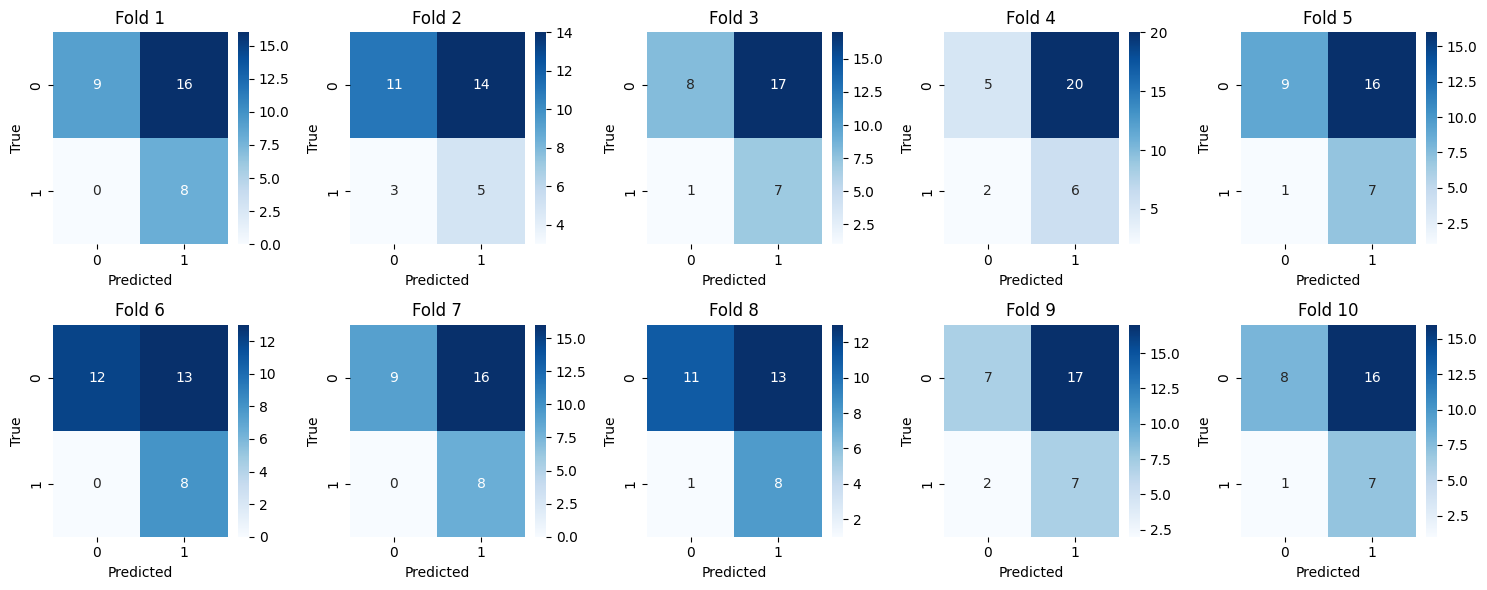

Model best parameters: {'oversampler__k_neighbors': 3, 'oversampler__borderline': False, 'model__learning_rate': 1.4, 'feature_selector__k': 4}


In [14]:
f_macro_scores3 = []
clfADAGNB, best_params, reports = \
    Stratified10KFoldValidation(clf_AdaBoostGNB, param_grid_AdaBoostGNB, train_data, train_labels, scorer, skf)
print("Model best parameters:", best_params)
for report in reports:
    f_macro_scores3.append(report["macro avg"]["f1-score"])

              precision    recall  f1-score   support

          no       0.92      0.48      0.63        25
         yes       0.35      0.88      0.50         8

    accuracy                           0.58        33
   macro avg       0.64      0.68      0.57        33
weighted avg       0.78      0.58      0.60        33

              precision    recall  f1-score   support

          no       0.75      0.60      0.67        25
         yes       0.23      0.38      0.29         8

    accuracy                           0.55        33
   macro avg       0.49      0.49      0.48        33
weighted avg       0.62      0.55      0.57        33

              precision    recall  f1-score   support

          no       0.92      0.44      0.59        25
         yes       0.33      0.88      0.48         8

    accuracy                           0.55        33
   macro avg       0.62      0.66      0.54        33
weighted avg       0.78      0.55      0.57        33

              preci

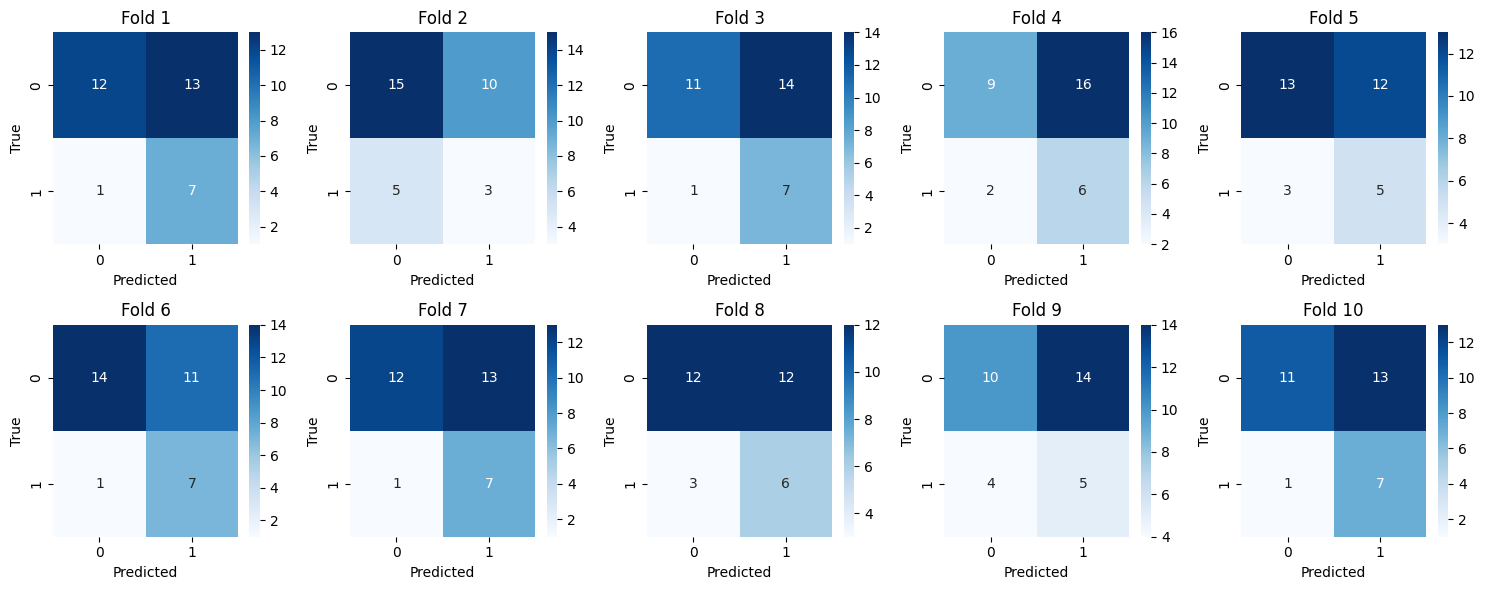

Model best parameters: {'oversampler__k_neighbors': 3, 'oversampler__borderline': True, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (64,), 'model__activation': 'logistic', 'feature_selector__k': 4}


In [15]:
f_macro_scores4 = []
clfNN, best_params, reports = \
    Stratified10KFoldValidation(clf_NeuralNetwork, param_grid_NeuralNetwork, train_data, train_labels, scorer, skf)
print("Model best parameters:", best_params)
for report in reports:
    f_macro_scores4.append(report["macro avg"]["f1-score"])

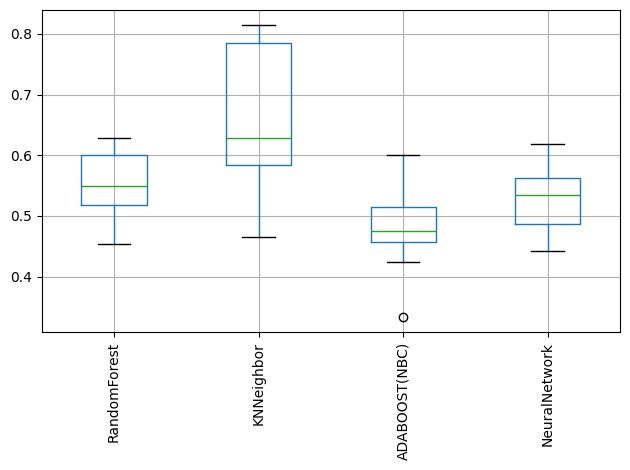

In [16]:
import matplotlib.pyplot as plt

cv_scores = {
    'RandomForest': f_macro_scores1,
    'KNNeighbor': f_macro_scores2,
    'ADABOOST(NBC)': f_macro_scores3,
    'NeuralNetwork': f_macro_scores4
}

df_cv_scores = pd.DataFrame(cv_scores)

df_cv_scores.boxplot()
plt.xticks(ticks=range(1, len(df_cv_scores.columns) + 1), labels=df_cv_scores.columns, rotation=90)
plt.tight_layout()
plt.show()

c:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


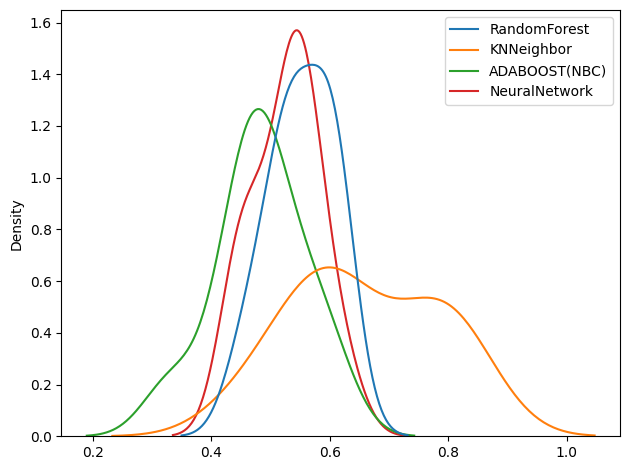

In [17]:
import scipy.stats as stats
import seaborn as sns

sns.kdeplot(data=df_cv_scores)
plt.tight_layout()
plt.show()

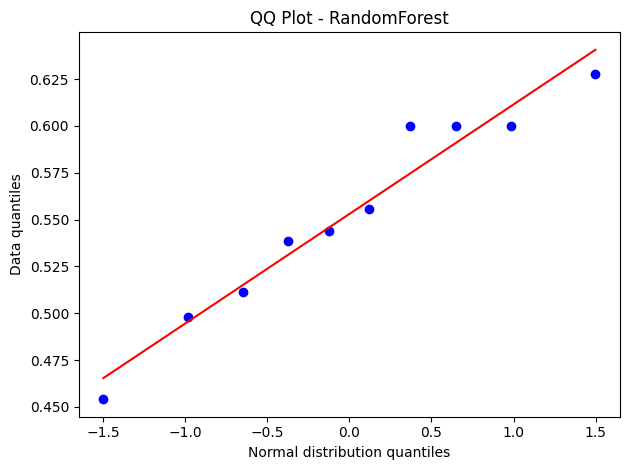

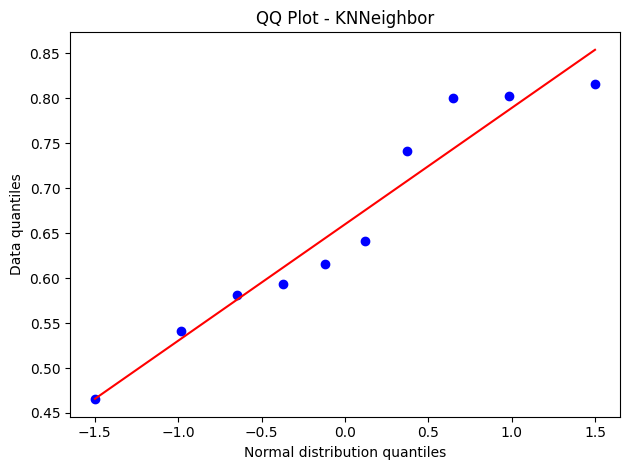

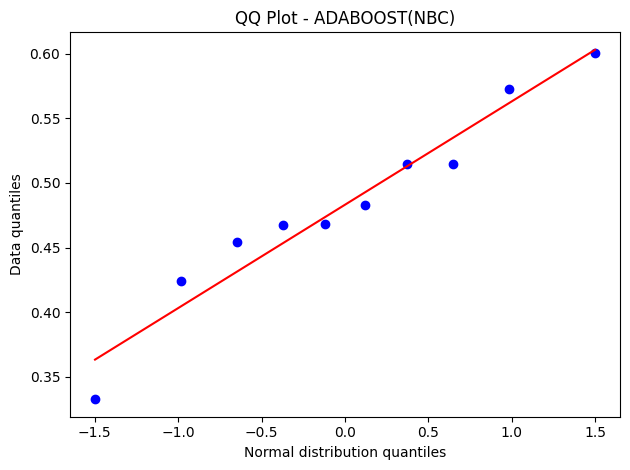

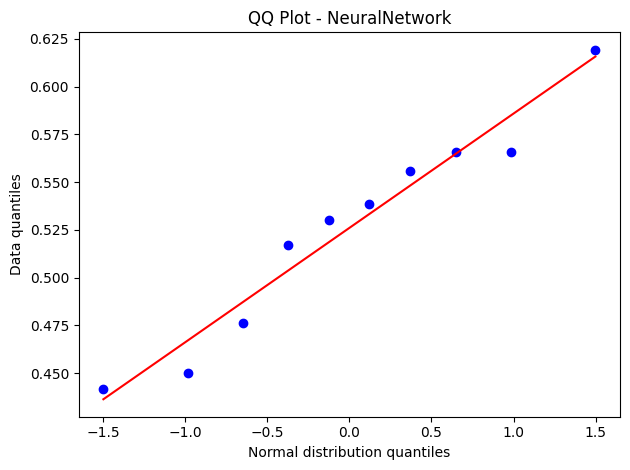

In [18]:
for i, col in enumerate(df_cv_scores.columns):
    stats.probplot(df_cv_scores[col], plot=plt)
    plt.title(f'QQ Plot - {col}')
    plt.xlabel('Normal distribution quantiles')
    plt.ylabel('Data quantiles')
    plt.tight_layout()

    plt.show()

In [19]:
statistic, p_value = stats.levene(cv_scores["RandomForest"], 
                                 cv_scores["KNNeighbor"], 
                                 cv_scores["ADABOOST(NBC)"],
                                 cv_scores['NeuralNetwork'])

print("Levene's statistic:", statistic)
print("p value:", p_value)

if p_value < 0.05:
    print("There is evidence to reject the null hypothesis of equal variances.")
else:
    print("There is no evidence to reject the null hypothesis of equal variances.")

Levene's statistic: 3.0813347465899357
p value: 0.03950769456462967
There is evidence to reject the null hypothesis of equal variances.


In [20]:
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import wilcoxon

kruskal_result = kruskal(cv_scores["RandomForest"], 
                         cv_scores["KNNeighbor"], 
                         cv_scores["ADABOOST(NBC)"],
                         cv_scores['NeuralNetwork']) 

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least two groups.")
    models = ["RandomForest", "KNNeighbor", "ADABOOST(NBC)", "NeuralNetwork"]
    couples = list(combinations(models, 2))
    
    for _ in couples:
        m1, m2 = _
        wilcoxon_result = wilcoxon(cv_scores[m1], cv_scores[m2])
        
        print("Comparing", m1, "and", m2)
        print("Wilcoxon statistic:", wilcoxon_result.statistic)
        print("p value:", wilcoxon_result.pvalue)
        
        if wilcoxon_result.pvalue < 0.05:
            print("There is a statistically relevant difference between", m1, "and", m2)
        else:
            print("There is no statistically relevant difference between", m1, "and", m2)
        print("----")
else:
    print("There are no statistically relevant difference between groups.")

Kruskal-Wallis statistic: 13.255091114033423
p value: 0.004116208594581014
There is a statistically relevant difference between at least two groups.
Comparing RandomForest and KNNeighbor
Wilcoxon statistic: 8.0
p value: 0.048828125
There is a statistically relevant difference between RandomForest and KNNeighbor
----
Comparing RandomForest and ADABOOST(NBC)
Wilcoxon statistic: 0.0
p value: 0.007685794055213263
There is a statistically relevant difference between RandomForest and ADABOOST(NBC)
----
Comparing RandomForest and NeuralNetwork
Wilcoxon statistic: 20.0
p value: 0.4921875
There is no statistically relevant difference between RandomForest and NeuralNetwork
----
Comparing KNNeighbor and ADABOOST(NBC)
Wilcoxon statistic: 1.0
p value: 0.00390625
There is a statistically relevant difference between KNNeighbor and ADABOOST(NBC)
----
Comparing KNNeighbor and NeuralNetwork
Wilcoxon statistic: 6.0
p value: 0.02734375
There is a statistically relevant difference between KNNeighbor and Ne

              precision    recall  f1-score   support

          no       1.00      0.79      0.88        14
         yes       0.57      1.00      0.73         4

    accuracy                           0.83        18
   macro avg       0.79      0.89      0.80        18
weighted avg       0.90      0.83      0.85        18



<Axes: >

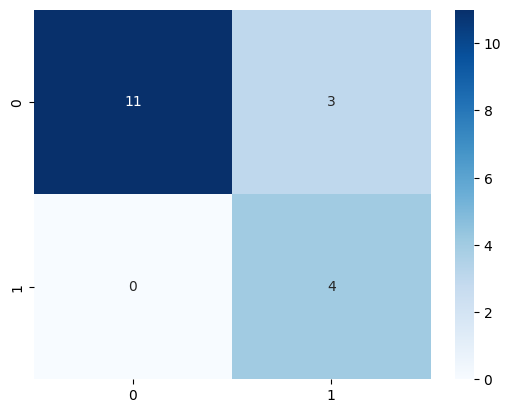

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clfKNN.predict(test_data)

report = classification_report(test_labels, y_pred, output_dict=False)
print(report)

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')